In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
import anndata
import umap.umap_ as umap
import leidenalg
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from sklearn.cluster import KMeans
from scipy.spatial.distance import pdist, squareform
from sklearn.metrics import pairwise_distances
from scipy.stats import zscore
from matplotlib.colorbar import ColorbarBase
import matplotlib.colors as mcolors

%matplotlib inline

In [2]:
plt.style.use('dark_background')

In [18]:
plt.style.use('default')

# Xenium Analysis

In [23]:
c3m1_cells = pd.read_csv(r"D:\SMI-0214_DonCleveland_UCSD\SMI-0214_DonCleveland_UCSD\xenium_prerelease_molina_mouse_brain_Mar13\C3m1\cells.csv.gz")
c3m1_cells

,cell_id,x_centroid,y_centroid,transcript_counts,control_probe_counts,control_codeword_counts,unassigned_codeword_counts,total_counts,cell_area,nucleus_area
0,1,1470.409833,4249.051636,4,0,0,0,4,178.186563,44.704687
1,2,1474.557941,4239.123071,12,0,0,0,12,50.439531,29.487031
2,3,1474.138440,4230.722266,34,0,0,0,34,251.430000,54.639063
3,4,1479.313043,4242.560010,3,0,0,0,3,50.665312,23.345781
4,5,1486.422662,4240.159839,6,0,0,0,6,59.199844,29.712812
...,...,...,...,...,...,...,...,...,...,...
52519,52520,5460.260132,4814.415771,51,0,0,0,51,134.114063,14.811250
52520,52521,5464.195117,4851.216040,196,0,0,0,196,359.443750,47.775313
52521,52522,5464.681958,4790.854834,430,0,0,1,431,740.065781,47.323750
52522,52523,5483.099731,4832.196875,161,1,0,0,162,386.221406,17.249688


In [24]:
sample_id_list = ['C3m1', 'C3m2', 'C3m3', 'C24m1', 'C24m2', 'C24m3', 'HD24m1', 'HD24m2', 'HD24m3', 'R61']

In [29]:
concated_cell_csv = pd.DataFrame()
for sample_id in sample_id_list:
    df = pd.read_csv(rf"D:\SMI-0214_DonCleveland_UCSD\SMI-0214_DonCleveland_UCSD\xenium_prerelease_molina_mouse_brain_Mar13\{sample_id}\cells.csv.gz")
    df['sample_id'] = sample_id
    concated_cell_csv = pd.concat([concated_cell_csv, df])

In [32]:
xenium_transcripts = concated_cell_csv['total_counts']
xenium_transcripts

0         4
1        12
2        34
3         3
4         6
         ..
62710     4
62711     0
62712     2
62713     1
62714     2
Name: total_counts, Length: 556343, dtype: int64

In [109]:
print(f'Xenium mean transcript count: {xenium_transcripts.mean()}')
print(f'Xenium standard deviation transcript count: {xenium_transcripts.std()}')
print(f'Xenium max transcript count: {xenium_transcripts.max()}')

Xenium mean transcript count: 207.7140433150053
Xenium standard deviation transcript count: 138.7766112726301
Xenium max transcript count: 1529


Text(0.5, 1.0, 'Xenium - Number of transcripts per cell')

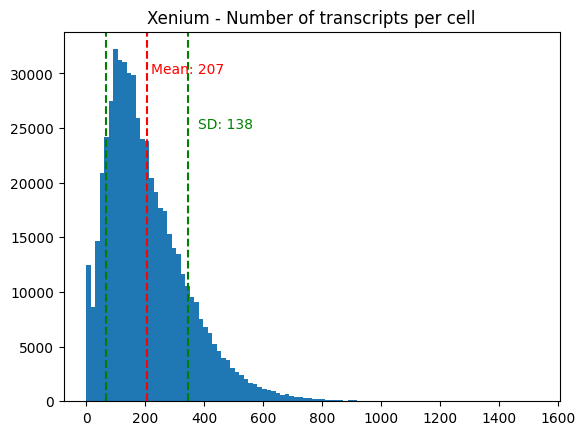

In [34]:
plt.hist(xenium_transcripts, bins = 100)
plt.axvline(xenium_transcripts.mean(), color = 'red', linestyle = 'dashed', label = 'Mean')
plt.text(220, 30000, f'Mean: {int(xenium_transcripts.mean())}', color = 'red')
plt.axvline(xenium_transcripts.mean() - xenium_transcripts.std(), color = 'green', linestyle = 'dashed', label = '-1 SD')
plt.text(380, 25000, f'SD: {int(xenium_transcripts.std())}', color = 'green')
plt.axvline(xenium_transcripts.mean() + xenium_transcripts.std(), color = 'green', linestyle = 'dashed', label = '+1 SD')
plt.title('Xenium - Number of transcripts per cell')

# Cosmx analysis

In [66]:
cosmx_gene_exp = pd.read_csv(r"D:\SMI-0214_DonCleveland_UCSD\SMI-0214_DonCleveland_UCSD\5 Raw data\MsBrain_exprMat_file.csv")
cosmx_gene_exp = cosmx_gene_exp.drop(columns = ['fov', 'cell_ID'])
cosmx_gene_exp

,Chrna4,Slc6a1,Cd109,Ldha,Aldoc,Drd1,Tank,Rit2,Prkag2,Lpar3,...,NegPrb1,NegPrb2,NegPrb3,NegPrb4,NegPrb5,NegPrb6,NegPrb7,NegPrb8,NegPrb9,NegPrb10
0,6,19,11,27,106,17,15,14,6,8,...,3,1,6,6,7,14,1,8,5,6
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
134768,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
134769,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
134770,0,1,0,0,3,0,1,0,0,2,...,0,0,0,0,0,0,0,0,0,0
134771,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [71]:
cosmx_gene_exp_revised = cosmx_gene_exp.iloc[:, :-10]
cosmx_transcript_counts = cosmx_gene_exp_revised.sum(axis = 1)
cosmx_transcript_counts

0         17818
1             0
2            14
3            26
4            12
          ...  
134768       60
134769       42
134770      308
134771      108
134772      200
Length: 134773, dtype: int64

In [110]:
print(f'Cosmx mean transcript count: {cosmx_transcript_counts.mean()}')
print(f'Cosmx standard deviation transcript count: {cosmx_transcript_counts.std()}')
print(f'Cosmx max transcript count: {cosmx_transcript_counts.max()}')

Cosmx mean transcript count: 524.3128445608542
Cosmx standard deviation transcript count: 2338.775609728052
Cosmx max transcript count: 129447


Text(0.5, 1.0, 'Cosmx - Number of transcripts per cell')

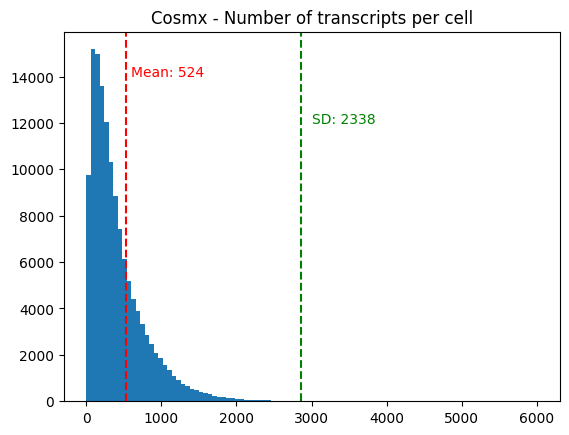

In [111]:
plt.hist(cosmx_transcript_counts, bins = 100, range = (0, 6000))
plt.axvline(cosmx_transcript_counts.mean(), color = 'red', linestyle = 'dashed', label = 'Mean')
plt.text(600, 14000, f'Mean: {int(cosmx_transcript_counts.mean())}', color = 'red')
#plt.axvline(cosmx_transcript_counts.mean() - cosmx_transcript_counts.std(), color = 'green', linestyle = 'dashed', label = '-1 SD')
plt.text(3000, 12000, f'SD: {int(cosmx_transcript_counts.std())}', color = 'green')
plt.axvline(cosmx_transcript_counts.mean() + cosmx_transcript_counts.std(), color = 'green', linestyle = 'dashed', label = '+1 SD')
plt.title('Cosmx - Number of transcripts per cell')

# Vizgen analysis

In [122]:
region_list = ['Region 0', 'Region 1', 'Region 2', 'Region 3']

In [124]:
vizgen_concat = pd.DataFrame()
for region in region_list:
    df = pd.read_csv(rf"D:\SMI-0214_DonCleveland_UCSD\SMI-0214_DonCleveland_UCSD\Vizgen Analysis\{region}\detected_transcripts.csv")
    df['sample_id'] = region
    df_revised = df[df['cell_id'] != -1]
    df_revised1 = df_revised.groupby(['cell_id','gene']).count()[['transcript_id']].reset_index()
    gene_exp = df_revised1.pivot_table(index='cell_id', columns='gene', values='transcript_id', fill_value=0)
    vizgen_concat = pd.concat([vizgen_concat, gene_exp])

In [129]:
vizgen_transcript_counts = vizgen_concat.sum(axis=1)
vizgen_transcript_counts

cell_id
4407145100026100001     2
4407145100026100002     3
4407145100026100003    26
4407145100026100012     2
4407145100026100014     1
                       ..
4407145601700100052     1
4407145601700100065     1
4407145601701100007     1
4407145601703100144     1
4407145601704100128     1
Length: 395424, dtype: int64

In [130]:
print(f'Vizgen mean transcript count: {vizgen_transcript_counts.mean()}')
print(f'Vizgen standard deviation transcript count: {vizgen_transcript_counts.std()}')
print(f'Vizgen max transcript count: {vizgen_transcript_counts.max()}')

Vizgen mean transcript count: 151.59098587844946
Vizgen standard deviation transcript count: 258.38750025655287
Vizgen max transcript count: 9458


Text(0.5, 1.0, 'Vizgen - Number of transcripts per cell')

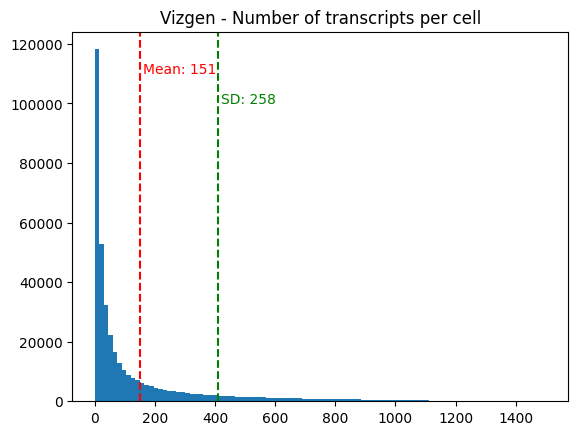

In [135]:
plt.hist(vizgen_transcript_counts, bins = 100, range = (0,1500))
plt.axvline(vizgen_transcript_counts.mean(), color = 'red', linestyle = 'dashed', label = 'Mean')
plt.text(160, 110000, f'Mean: {int(vizgen_transcript_counts.mean())}', color = 'red')
#plt.axvline(vizgen_transcript_counts.mean() - vizgen_transcript_counts.std(), color = 'green', linestyle = 'dashed', label = '-1 SD')
plt.text(420, 100000, f'SD: {int(vizgen_transcript_counts.std())}', color = 'green')
plt.axvline(vizgen_transcript_counts.mean() + vizgen_transcript_counts.std(), color = 'green', linestyle = 'dashed', label = '+1 SD')
plt.title('Vizgen - Number of transcripts per cell')

# Cbm2 analysis

In [176]:
cbm2_scdata = sc.read_h5ad(r"C:\Users\krist\Cleveland Lab Group\activation_of_quiescent_neurogenic_niches_of_aging_brain\CBM2_new_immmature_dg.h5ad")
cbm2_scdata

AnnData object with n_obs × n_vars = 57489 × 223
    obs: 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'leiden', 'Experiment', 'Age', 'Mouse', 'Section', 'Treatment', 'celltype', 'MERFISH celltype'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'leiden', 'leiden_colors', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_spatial', 'X_umap'
    obsp: 'connectivities', 'distances'

In [180]:
cbm2_transcript_counts = cbm2_scdata.obs['total_counts']
cbm2_transcript_counts

cell_id
2          1788.0
4          1018.0
10          959.0
12         3963.0
14         2720.0
            ...  
4840191     160.0
4840192     297.0
4840193     125.0
4840194     114.0
4840197      76.0
Name: total_counts, Length: 57489, dtype: float32

In [182]:
print(f'Cbm2 mean transcript count: {cbm2_transcript_counts.mean()}')
print(f'Cbm2 standard deviation transcript count: {cbm2_transcript_counts.std()}')
print(f'Cbm2 max transcript count: {cbm2_transcript_counts.max()}')

Cbm2 mean transcript count: 1397.2408447265625
Cbm2 standard deviation transcript count: 1131.2724609375
Cbm2 max transcript count: 8552.0


Text(0.5, 1.0, 'Cbm2 - Number of transcripts per cell')

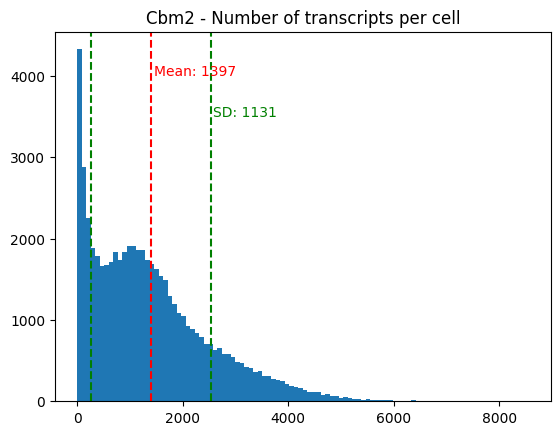

In [192]:
plt.hist(cbm2_transcript_counts, bins = 100)
plt.axvline(cbm2_transcript_counts.mean(), color = 'red', linestyle = 'dashed', label = 'Mean')
plt.text(1450, 4000, f'Mean: {int(cbm2_transcript_counts.mean())}', color = 'red')
plt.axvline(cbm2_transcript_counts.mean() - cbm2_transcript_counts.std(), color = 'green', linestyle = 'dashed', label = '-1 SD')
plt.text(2570, 3500, f'SD: {int(cbm2_transcript_counts.std())}', color = 'green')
plt.axvline(cbm2_transcript_counts.mean() + cbm2_transcript_counts.std(), color = 'green', linestyle = 'dashed', label = '+1 SD')
plt.title('Cbm2 - Number of transcripts per cell')

# Number of genes in each method

In [141]:
xenium_scdata = sc.read_h5ad(r"D:\SMI-0214_DonCleveland_UCSD\SMI-0214_DonCleveland_UCSD\Xenium_mouse_filtered.h5ad")
xenium_scdata

AnnData object with n_obs × n_vars = 547139 × 248
    obs: 'cell_id', 'Sample ID', 'Number of genes', 'Number of transcripts', 'leiden', 'cluster_names'
    uns: 'Sample ID_colors', 'cell_id_colors', 'cluster_names_colors', 'leiden', 'leiden_colors', 'neighbors', 'pca', 'rank_genes_groups'
    obsm: 'X_pca', 'X_spatial', 'X_spatial_rescaled', 'X_spatial_rescaled_flipped', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [181]:
cbm2_scdata

AnnData object with n_obs × n_vars = 57489 × 223
    obs: 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'leiden', 'Experiment', 'Age', 'Mouse', 'Section', 'Treatment', 'celltype', 'MERFISH celltype'
    var: 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'leiden', 'leiden_colors', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_spatial', 'X_umap'
    obsp: 'connectivities', 'distances'

In [159]:
print (f'Xenium gene panel size: {len(xenium_scdata.var)}')
print (f'Cosmx gene panel size: {cosmx_gene_exp_revised.shape[1]}')
print (f'Vizgen gene panel size: {vizgen_concat.shape[1]}')
print (f'Cbm2 gene panel size: {len(cbm2_scdata.var)}')

Xenium gene panel size: 248
Cosmx gene panel size: 950
Vizgen gene panel size: 550
Cbm2 gene panel size: 223


### Gene overlap panel

In [161]:
xenium_gene_df = pd.DataFrame({'genes': xenium_scdata.var.index})
cosmx_gene_df = pd.DataFrame({'genes': cosmx_gene_exp_revised.columns})
vizgen_gene_df = pd.DataFrame({'genes': vizgen_concat.columns})
cbm2_gene_df = pd.DataFrame({'genes': cbm2_scdata.var.index})

In [173]:
gene_overlap_df = xenium_gene_df.merge(cosmx_gene_df, on = 'genes').merge(vizgen_gene_df, on = 'genes').merge(cbm2_gene_df, on = 'genes')
gene_overlap_df

,genes
0,Acta2
1,Aqp4
2,Bdnf
3,Calb1
4,Cldn5
5,Fos
6,Gad1
7,Gfap
8,Gpr17
9,Npy2r


### Generate histograms using only overlap

In [174]:
gene_overlap_list = list(gene_overlap_list['genes'])
gene_overlap_list

['Acta2',
 'Aqp4',
 'Bdnf',
 'Calb1',
 'Cldn5',
 'Fos',
 'Gad1',
 'Gfap',
 'Gpr17',
 'Npy2r',
 'Pdgfra',
 'Vip']

##### Xenium overlap histogram

In [242]:
xenium_cell_df = pd.DataFrame(columns = xenium_scdata.var.index)
for sample in sample_id_list:
    mtx = sc.read_10x_h5(rf"D:\SMI-0214_DonCleveland_UCSD\SMI-0214_DonCleveland_UCSD\xenium_prerelease_molina_mouse_brain_Mar13\{sample}\cell_feature_matrix.h5")
    xenium_cell_df = pd.concat([xenium_cell_df, pd.DataFrame(mtx.X.toarray(), columns = xenium_scdata.var.index)], ignore_index = True)

In [245]:
xenium_overlap = xenium_cell_df.loc[:, [gene for gene in xenium_cell_df.columns if gene in gene_overlap_list]]
xenium_overlap

,Acta2,Aqp4,Bdnf,Calb1,Cldn5,Fos,Gad1,Gfap,Gpr17,Npy2r,Pdgfra,Vip
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
556338,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
556339,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
556340,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
556341,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [246]:
xenium_overlap_transcript_count = xenium_overlap.sum(axis = 1)
xenium_overlap_transcript_count

0         0.0
1         0.0
2         0.0
3         0.0
4         0.0
         ... 
556338    0.0
556339    0.0
556340    0.0
556341    0.0
556342    0.0
Length: 556343, dtype: float32

In [247]:
print(f'Xenium Overlap mean transcript count: {xenium_overlap_transcript_count.mean()}')
print(f'Xenium Overlap standard deviation transcript count: {xenium_overlap_transcript_count.std()}')
print(f'Xenium Overlap max transcript count: {xenium_overlap_transcript_count.max()}')

Xenium Overlap mean transcript count: 13.643061637878418
Xenium Overlap standard deviation transcript count: 13.672500610351562
Xenium Overlap max transcript count: 225.0


Text(0.5, 1.0, 'Xenium Overlap - Number of transcripts per cell')

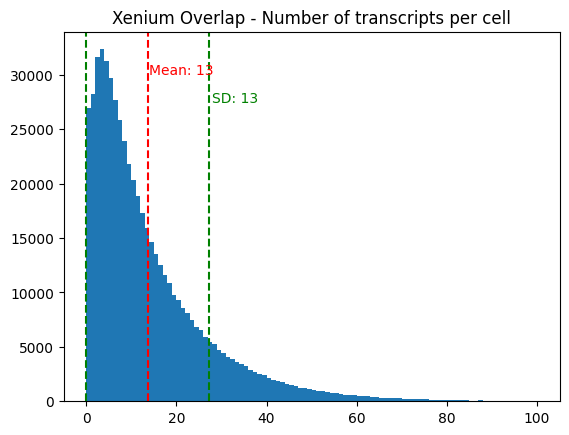

In [251]:
plt.hist(xenium_overlap_transcript_count, bins = 100, range = (0,100))
plt.axvline(xenium_overlap_transcript_count.mean(), color = 'red', linestyle = 'dashed', label = 'Mean')
plt.text(14, 30000, f'Mean: {int(xenium_overlap_transcript_count.mean())}', color = 'red')
plt.axvline(xenium_overlap_transcript_count.mean() - xenium_overlap_transcript_count.std(), color = 'green', linestyle = 'dashed', label = '-1 SD')
plt.text(28, 27500, f'SD: {int(xenium_overlap_transcript_count.std())}', color = 'green')
plt.axvline(xenium_overlap_transcript_count.mean() + xenium_overlap_transcript_count.std(), color = 'green', linestyle = 'dashed', label = '+1 SD')
plt.title('Xenium Overlap - Number of transcripts per cell')

##### Cosmx overlap histogram

In [194]:
cosmx_overlap = cosmx_gene_exp_revised.loc[:, [gene for gene in cosmx_gene_exp_revised.columns if gene in gene_overlap_list]]
cosmx_overlap

,Pdgfra,Gad1,Vip,Cldn5,Calb1,Npy2r,Fos,Gpr17,Acta2,Gfap,Bdnf,Aqp4
0,6,22,9,12,14,12,13,18,7,51,15,34
1,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
134768,0,0,0,0,0,0,0,0,0,0,0,0
134769,0,0,0,0,0,0,0,0,0,0,0,0
134770,1,0,0,0,0,0,1,0,0,0,0,0
134771,0,0,0,0,0,0,0,1,0,1,0,0


In [196]:
cosmx_overlap_transcript_count = cosmx_overlap.sum(axis = 1)
cosmx_overlap_transcript_count

0         213
1           0
2           0
3           0
4           0
         ... 
134768      0
134769      0
134770      2
134771      2
134772      3
Length: 134773, dtype: int64

In [197]:
print(f'Cosmx overlap mean transcript count: {cosmx_overlap_transcript_count.mean()}')
print(f'Cosmx overlap standard deviation transcript count: {cosmx_overlap_transcript_count.std()}')
print(f'Cosmx overlap max transcript count: {cosmx_overlap_transcript_count.max()}')

Cosmx overlap mean transcript count: 3.717309846927797
Cosmx overlap standard deviation transcript count: 15.199948721267194
Cosmx overlap max transcript count: 1013


Text(0.5, 1.0, 'Cosmx Overlap - Number of transcripts per cell')

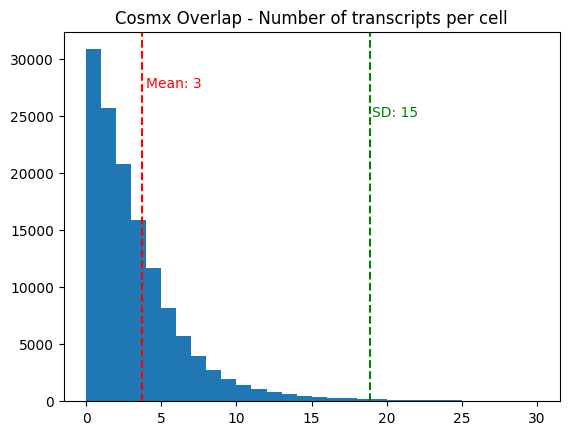

In [206]:
plt.hist(cosmx_overlap_transcript_count, bins = 30, range = (0,30))
plt.axvline(cosmx_overlap_transcript_count.mean(), color = 'red', linestyle = 'dashed', label = 'Mean')
plt.text(4, 27500, f'Mean: {int(cosmx_overlap_transcript_count.mean())}', color = 'red')
#plt.axvline(cosmx_overlap_transcript_count.mean() - cosmx_overlap_transcript_count.std(), color = 'green', linestyle = 'dashed', label = '-1 SD')
plt.text(19, 25000, f'SD: {int(cosmx_overlap_transcript_count.std())}', color = 'green')
plt.axvline(cosmx_overlap_transcript_count.mean() + cosmx_overlap_transcript_count.std(), color = 'green', linestyle = 'dashed', label = '+1 SD')
plt.title('Cosmx Overlap - Number of transcripts per cell')

##### Vizgen overlap histogram

In [210]:
vizgen_overlap = vizgen_concat.loc[:, [gene for gene in vizgen_concat.columns if gene in gene_overlap_list]]
vizgen_overlap

gene,Acta2,Aqp4,Bdnf,Calb1,Cldn5,Fos,Gad1,Gfap,Gpr17,Npy2r,Pdgfra,Vip
cell_id,,,,,,,,,,,,
4407145100026100001,0,0,0,0,0,0,0,0,0,0,0,0
4407145100026100002,0,0,0,0,0,0,0,0,0,0,0,0
4407145100026100003,0,0,0,0,0,0,0,0,0,0,0,0
4407145100026100012,0,0,0,0,0,0,0,0,0,0,0,0
4407145100026100014,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
4407145601700100052,0,0,0,0,0,0,0,0,0,0,0,0
4407145601700100065,0,0,0,0,0,0,0,0,0,0,0,0
4407145601701100007,0,0,0,0,0,0,0,0,0,0,0,0


In [211]:
vizgen_overlap_transcript_counts = vizgen_overlap.sum(axis = 1)
vizgen_overlap_transcript_counts

cell_id
4407145100026100001    0
4407145100026100002    0
4407145100026100003    0
4407145100026100012    0
4407145100026100014    0
                      ..
4407145601700100052    0
4407145601700100065    0
4407145601701100007    0
4407145601703100144    0
4407145601704100128    0
Length: 395424, dtype: int64

In [212]:
print(f'Vizgen overlap mean transcript count: {vizgen_overlap_transcript_counts.mean()}')
print(f'Vizgen overlap standard deviation transcript count: {vizgen_overlap_transcript_counts.std()}')
print(f'Vizgen overlap max transcript count: {vizgen_overlap_transcript_counts.max()}')

Vizgen overlap mean transcript count: 7.130859533058185
Vizgen overlap standard deviation transcript count: 19.627672457941614
Vizgen overlap max transcript count: 721


Text(0.5, 1.0, 'Vizgen Overlap - Number of transcripts per cell')

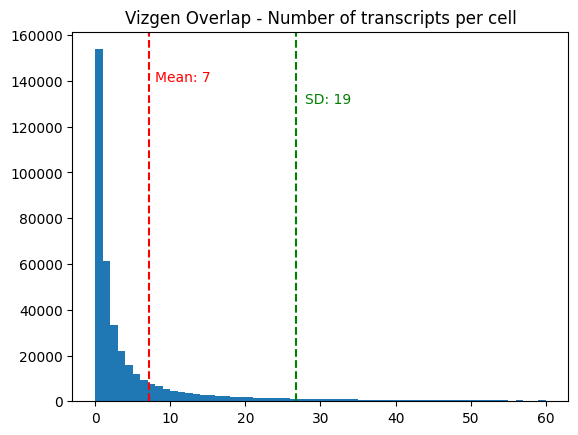

In [217]:
plt.hist(vizgen_overlap_transcript_counts, bins = 60, range = (0,60))
plt.axvline(vizgen_overlap_transcript_counts.mean(), color = 'red', linestyle = 'dashed', label = 'Mean')
plt.text(8, 140000, f'Mean: {int(vizgen_overlap_transcript_counts.mean())}', color = 'red')
#plt.axvline(vizgen_overlap_transcript_counts.mean() - vizgen_overlap_transcript_counts.std(), color = 'green', linestyle = 'dashed', label = '-1 SD')
plt.text(28, 130000, f'SD: {int(vizgen_overlap_transcript_counts.std())}', color = 'green')
plt.axvline(vizgen_overlap_transcript_counts.mean() + vizgen_overlap_transcript_counts.std(), color = 'green', linestyle = 'dashed', label = '+1 SD')
plt.title('Vizgen Overlap - Number of transcripts per cell')

##### Cbm2 overlap histogram

In [261]:
cmb2_cell_df = pd.read_csv(r"D:\SMI-0214_DonCleveland_UCSD\SMI-0214_DonCleveland_UCSD\cbm2_single_cell_raw_counts.csv")
cmb2_cell_df

,cell_id,4930570B17Rik,Abhd2,Acer3,Acta2,Adcy1,Adcy2,Adgrl3,Agt,Ahcyl2,...,Unc13b,Unc13c,Unc5c,Vim,Vip,Vps13c,Wdr17,Wfs1,Wipf3,Zfp36l1
0,2,0,0,5,6,17,2,6,83,5,...,0,5,0,0,0,3,0,3,4,17
1,4,0,0,1,0,5,0,11,0,12,...,0,1,9,0,0,7,0,6,0,6
2,10,0,28,0,2,0,0,4,7,2,...,0,5,0,10,0,0,0,1,0,14
3,12,0,7,8,5,12,1,42,31,16,...,3,3,8,2,0,33,4,15,6,2
4,14,0,15,7,2,10,4,28,0,16,...,9,0,8,3,0,45,5,11,8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58187,4840191,0,3,0,0,0,0,0,6,0,...,0,0,0,0,0,0,0,0,0,0
58188,4840192,0,0,0,0,1,3,0,12,0,...,0,0,0,0,0,0,0,4,0,0
58189,4840193,0,1,0,0,0,2,1,0,0,...,0,0,0,0,0,2,0,1,0,0
58190,4840194,0,1,0,7,0,0,0,0,0,...,0,0,0,4,0,0,0,0,0,2


In [263]:
cbm2_overlap = cmb2_cell_df.loc[:, [gene for gene in cmb2_cell_df.columns if gene in gene_overlap_list]]
cbm2_overlap

,Acta2,Aqp4,Bdnf,Calb1,Cldn5,Fos,Gad1,Gfap,Gpr17,Npy2r,Pdgfra,Vip
0,6,17,0,2,0,1,0,0,0,0,0,0
1,0,0,0,8,0,0,0,0,1,2,0,0
2,2,1,1,1,40,0,0,1,0,1,0,0
3,5,3,7,34,1,2,1,2,4,2,3,0
4,2,0,4,14,0,8,0,1,2,14,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...
58187,0,0,0,0,0,0,1,0,1,0,0,0
58188,0,3,0,3,0,0,0,0,0,0,0,0
58189,0,0,0,0,0,0,0,0,0,0,0,0
58190,7,0,0,0,12,0,0,0,0,0,1,0


In [264]:
cbm2_overlap_transcript_counts = cbm2_overlap.sum(axis = 1)
cbm2_overlap_transcript_counts

0        26
1        11
2        47
3        64
4        47
         ..
58187     2
58188     6
58189     0
58190    20
58191     0
Length: 58192, dtype: int64

In [265]:
print(f'Cbm2 overlap mean transcript count: {cbm2_overlap_transcript_counts.mean()}')
print(f'Cbm2 overlap standard deviation transcript count: {cbm2_overlap_transcript_counts.std()}')
print(f'Cbm2 overlap max transcript count: {cbm2_overlap_transcript_counts.max()}')

Cbm2 overlap mean transcript count: 48.968122766015945
Cbm2 overlap standard deviation transcript count: 89.1659066895679
Cbm2 overlap max transcript count: 1559


Text(0.5, 1.0, 'Cbm2 Overlap - Number of transcripts per cell')

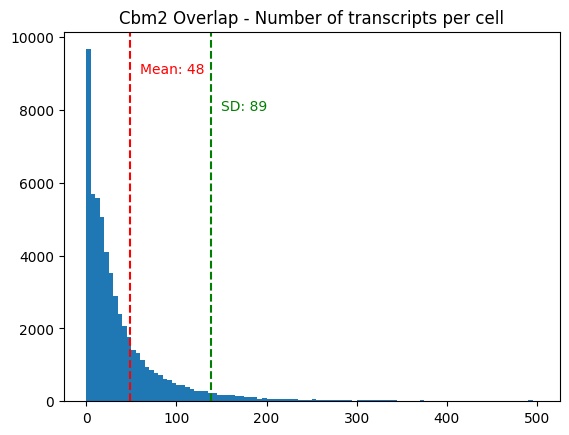

In [273]:
plt.hist(cbm2_overlap_transcript_counts, bins = 100, range = (0,500))
plt.axvline(cbm2_overlap_transcript_counts.mean(), color = 'red', linestyle = 'dashed', label = 'Mean')
plt.text(60, 9000, f'Mean: {int(cbm2_overlap_transcript_counts.mean())}', color = 'red')
#plt.axvline(cbm2_overlap_transcript_counts.mean() - cbm2_overlap_transcript_counts.std(), color = 'green', linestyle = 'dashed', label = '-1 SD')
plt.text(150, 8000, f'SD: {int(cbm2_overlap_transcript_counts.std())}', color = 'green')
plt.axvline(cbm2_overlap_transcript_counts.mean() + cbm2_overlap_transcript_counts.std(), color = 'green', linestyle = 'dashed', label = '+1 SD')
plt.title('Cbm2 Overlap - Number of transcripts per cell')

# Charts without SD

Text(0.5, 1.0, 'Xenium - Number of transcripts per cell')

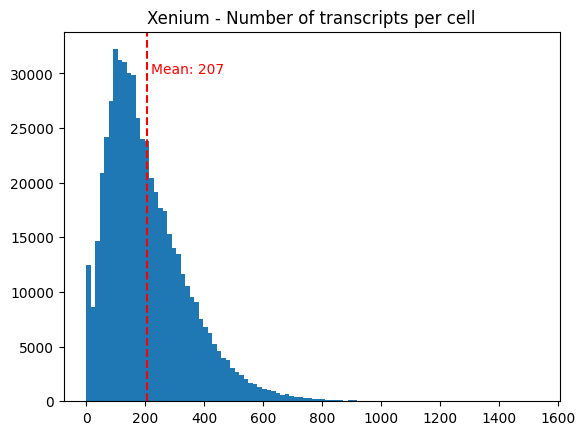

In [254]:
plt.hist(xenium_transcripts, bins = 100)
plt.axvline(xenium_transcripts.mean(), color = 'red', linestyle = 'dashed', label = 'Mean')
plt.text(220, 30000, f'Mean: {int(xenium_transcripts.mean())}', color = 'red')
#plt.axvline(xenium_transcripts.mean() - xenium_transcripts.std(), color = 'green', linestyle = 'dashed', label = '-1 SD')
#plt.text(380, 25000, f'SD: {int(xenium_transcripts.std())}', color = 'green')
#plt.axvline(xenium_transcripts.mean() + xenium_transcripts.std(), color = 'green', linestyle = 'dashed', label = '+1 SD')
plt.title('Xenium - Number of transcripts per cell')

Text(0.5, 1.0, 'Cosmx - Number of transcripts per cell')

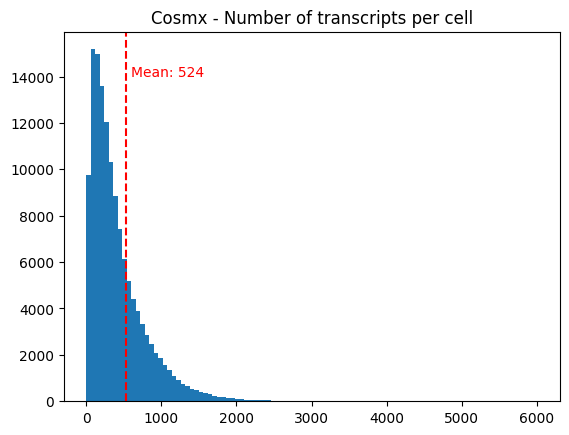

In [255]:
plt.hist(cosmx_transcript_counts, bins = 100, range = (0, 6000))
plt.axvline(cosmx_transcript_counts.mean(), color = 'red', linestyle = 'dashed', label = 'Mean')
plt.text(600, 14000, f'Mean: {int(cosmx_transcript_counts.mean())}', color = 'red')
#plt.axvline(cosmx_transcript_counts.mean() - cosmx_transcript_counts.std(), color = 'green', linestyle = 'dashed', label = '-1 SD')
#plt.text(3000, 12000, f'SD: {int(cosmx_transcript_counts.std())}', color = 'green')
#plt.axvline(cosmx_transcript_counts.mean() + cosmx_transcript_counts.std(), color = 'green', linestyle = 'dashed', label = '+1 SD')
plt.title('Cosmx - Number of transcripts per cell')

Text(0.5, 1.0, 'Vizgen - Number of transcripts per cell')

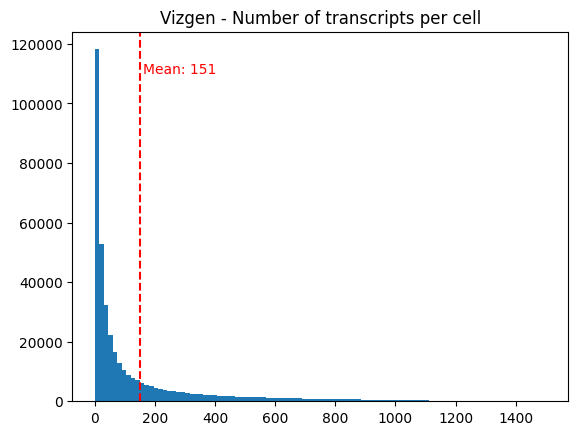

In [256]:
plt.hist(vizgen_transcript_counts, bins = 100, range = (0,1500))
plt.axvline(vizgen_transcript_counts.mean(), color = 'red', linestyle = 'dashed', label = 'Mean')
plt.text(160, 110000, f'Mean: {int(vizgen_transcript_counts.mean())}', color = 'red')
#plt.axvline(vizgen_transcript_counts.mean() - vizgen_transcript_counts.std(), color = 'green', linestyle = 'dashed', label = '-1 SD')
#plt.text(420, 100000, f'SD: {int(vizgen_transcript_counts.std())}', color = 'green')
#plt.axvline(vizgen_transcript_counts.mean() + vizgen_transcript_counts.std(), color = 'green', linestyle = 'dashed', label = '+1 SD')
plt.title('Vizgen - Number of transcripts per cell')

Text(0.5, 1.0, 'Cbm2 - Number of transcripts per cell')

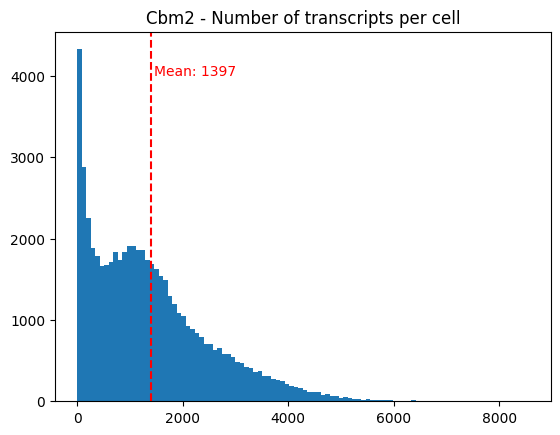

In [257]:
plt.hist(cbm2_transcript_counts, bins = 100)
plt.axvline(cbm2_transcript_counts.mean(), color = 'red', linestyle = 'dashed', label = 'Mean')
plt.text(1450, 4000, f'Mean: {int(cbm2_transcript_counts.mean())}', color = 'red')
#plt.axvline(cbm2_transcript_counts.mean() - cbm2_transcript_counts.std(), color = 'green', linestyle = 'dashed', label = '-1 SD')
#plt.text(2570, 3500, f'SD: {int(cbm2_transcript_counts.std())}', color = 'green')
#plt.axvline(cbm2_transcript_counts.mean() + cbm2_transcript_counts.std(), color = 'green', linestyle = 'dashed', label = '+1 SD')
plt.title('Cbm2 - Number of transcripts per cell')

Text(0.5, 1.0, 'Xenium Overlap - Number of transcripts per cell')

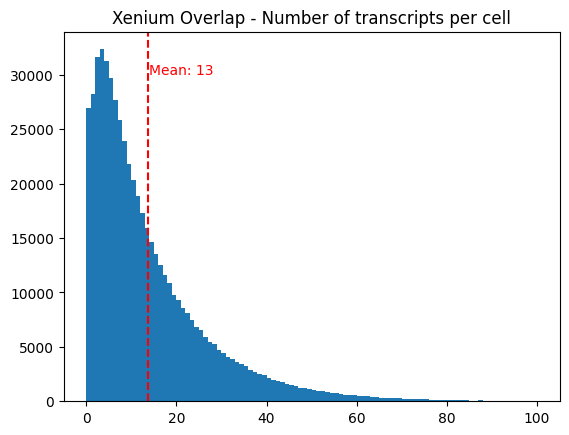

In [258]:
plt.hist(xenium_overlap_transcript_count, bins = 100, range = (0,100))
plt.axvline(xenium_overlap_transcript_count.mean(), color = 'red', linestyle = 'dashed', label = 'Mean')
plt.text(14, 30000, f'Mean: {int(xenium_overlap_transcript_count.mean())}', color = 'red')
#plt.axvline(xenium_overlap_transcript_count.mean() - xenium_overlap_transcript_count.std(), color = 'green', linestyle = 'dashed', label = '-1 SD')
#plt.text(28, 27500, f'SD: {int(xenium_overlap_transcript_count.std())}', color = 'green')
#plt.axvline(xenium_overlap_transcript_count.mean() + xenium_overlap_transcript_count.std(), color = 'green', linestyle = 'dashed', label = '+1 SD')
plt.title('Xenium Overlap - Number of transcripts per cell')

Text(0.5, 1.0, 'Cosmx Overlap - Number of transcripts per cell')

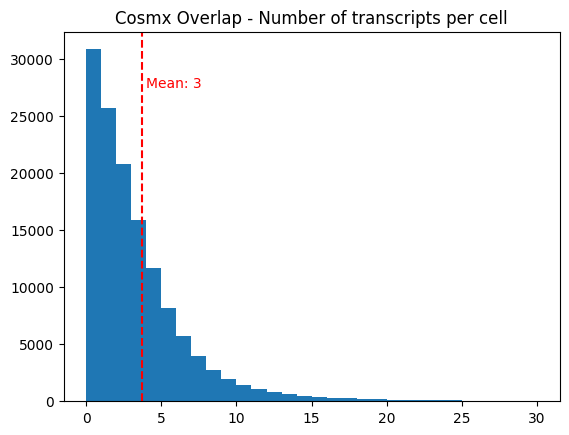

In [259]:
plt.hist(cosmx_overlap_transcript_count, bins = 30, range = (0,30))
plt.axvline(cosmx_overlap_transcript_count.mean(), color = 'red', linestyle = 'dashed', label = 'Mean')
plt.text(4, 27500, f'Mean: {int(cosmx_overlap_transcript_count.mean())}', color = 'red')
#plt.axvline(cosmx_overlap_transcript_count.mean() - cosmx_overlap_transcript_count.std(), color = 'green', linestyle = 'dashed', label = '-1 SD')
#plt.text(19, 25000, f'SD: {int(cosmx_overlap_transcript_count.std())}', color = 'green')
#plt.axvline(cosmx_overlap_transcript_count.mean() + cosmx_overlap_transcript_count.std(), color = 'green', linestyle = 'dashed', label = '+1 SD')
plt.title('Cosmx Overlap - Number of transcripts per cell')

Text(0.5, 1.0, 'Vizgen Overlap - Number of transcripts per cell')

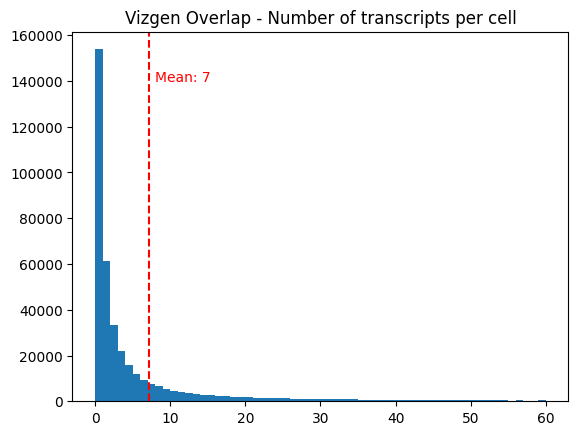

In [260]:
plt.hist(vizgen_overlap_transcript_counts, bins = 60, range = (0,60))
plt.axvline(vizgen_overlap_transcript_counts.mean(), color = 'red', linestyle = 'dashed', label = 'Mean')
plt.text(8, 140000, f'Mean: {int(vizgen_overlap_transcript_counts.mean())}', color = 'red')
#plt.axvline(vizgen_overlap_transcript_counts.mean() - vizgen_overlap_transcript_counts.std(), color = 'green', linestyle = 'dashed', label = '-1 SD')
#plt.text(28, 130000, f'SD: {int(vizgen_overlap_transcript_counts.std())}', color = 'green')
#plt.axvline(vizgen_overlap_transcript_counts.mean() + vizgen_overlap_transcript_counts.std(), color = 'green', linestyle = 'dashed', label = '+1 SD')
plt.title('Vizgen Overlap - Number of transcripts per cell')

Text(0.5, 1.0, 'Cbm2 Overlap - Number of transcripts per cell')

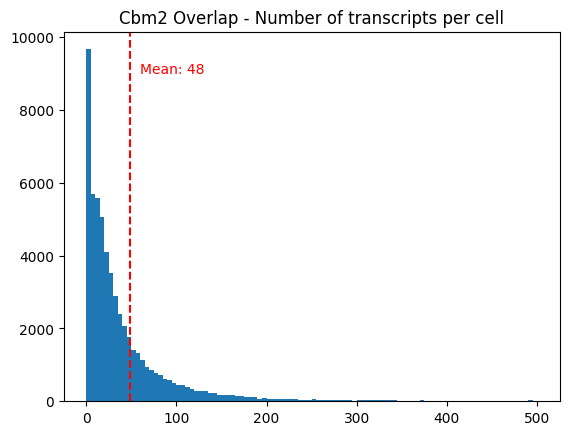

In [274]:
plt.hist(cbm2_overlap_transcript_counts, bins = 100, range = (0,500))
plt.axvline(cbm2_overlap_transcript_counts.mean(), color = 'red', linestyle = 'dashed', label = 'Mean')
plt.text(60, 9000, f'Mean: {int(cbm2_overlap_transcript_counts.mean())}', color = 'red')
#plt.axvline(cbm2_overlap_transcript_counts.mean() - cbm2_overlap_transcript_counts.std(), color = 'green', linestyle = 'dashed', label = '-1 SD')
#plt.text(150, 8000, f'SD: {int(cbm2_overlap_transcript_counts.std())}', color = 'green')
#plt.axvline(cbm2_overlap_transcript_counts.mean() + cbm2_overlap_transcript_counts.std(), color = 'green', linestyle = 'dashed', label = '+1 SD')
plt.title('Cbm2 Overlap - Number of transcripts per cell')